# 自动微分与优化

有了自动微分以后，对一大类机器学习的求解会非常方便。首先考虑一个简单的线性模型：

In [1]:
import math
import numpy as np
import torch

np.random.seed(123456)
torch.manual_seed(123456)
n = 100
p = 5

beta = torch.randn(p)
x = torch.randn(n, p)
y = torch.matmul(x, beta) + torch.randn(n) * math.sqrt(0.1)

我们将利用简单的梯度下降对 $\beta$ 进行优化。首先创建一个初始值并声明需要梯度：

In [2]:
bhat = torch.zeros(p)
bhat.requires_grad = True

编写损失函数：

In [3]:
def loss_fn(bhat, x, y):
    yhat = torch.matmul(x, bhat)
    return torch.mean(torch.square(y - yhat))

建立一个循环用来不断更新参数：

In [4]:
# 迭代次数
nepoch = 500
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

for i in range(nepoch):
    loss = loss_fn(bhat, x, y)

    loss.backward()
    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}, error = {torch.mean(torch.square(bhat - beta))}")

    with torch.no_grad():
        bhat -= learning_rate * bhat.grad
        
        # 清空梯度项
        bhat.grad = None

iteration 0, loss = 6.666600227355957, error = 1.300956130027771
iteration 50, loss = 0.8894939422607422, error = 0.17852996289730072
iteration 100, loss = 0.20490001142024994, error = 0.03156755119562149
iteration 150, loss = 0.11406506597995758, error = 0.007916359230875969
iteration 200, loss = 0.09939472377300262, error = 0.002928879577666521
iteration 250, loss = 0.09633128345012665, error = 0.0016137383645400405
iteration 300, loss = 0.09553373605012894, error = 0.001224947045557201
iteration 350, loss = 0.09529763460159302, error = 0.001107055344618857
iteration 400, loss = 0.09522350132465363, error = 0.0010728153865784407
iteration 450, loss = 0.09519967436790466, error = 0.0010642616543918848


画出损失函数值的图像：

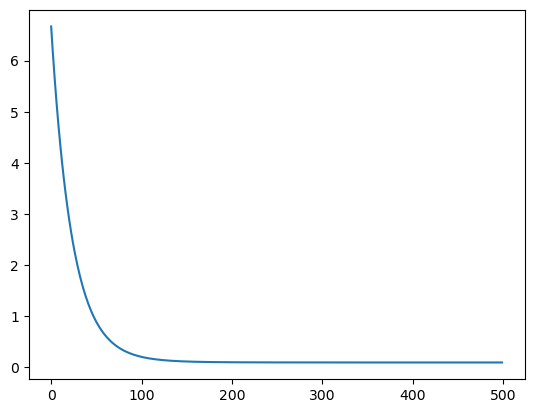

In [5]:
import matplotlib.pylab as plt
plt.plot(losses)

比较真实和估计的 $\beta$：

In [6]:
print(beta)
print(bhat)

tensor([ 1.8645,  0.4071, -1.1971,  0.3489, -1.1437])
tensor([ 1.8304,  0.4262, -1.1998,  0.3770, -1.0890], requires_grad=True)


# 模块化编程

PyTorch 中一种更常用的模型搭建和求解的方法是利用模块化编程，即将所有的参数装进一个类中，然后通过定义 `forward()` 函数来计算预测值。

In [7]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, beta_dim):
        super(MyModel, self).__init__()
        self.bhat = nn.Parameter(torch.zeros(beta_dim))

    def forward(self, x):
        yhat = torch.matmul(x, self.bhat)
        return yhat

np.random.seed(123456)
torch.random.manual_seed(123456)

model = MyModel(beta_dim=p)
print(list(model.parameters()))

[Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)]


In [8]:
# 迭代次数
nepoch = 500
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(nepoch):
    yhat = model(x)
    loss = torch.mean(torch.square(y - yhat))

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}")

iteration 0, loss = 6.666600227355957
iteration 50, loss = 0.8894939422607422
iteration 100, loss = 0.20490001142024994
iteration 150, loss = 0.11406506597995758
iteration 200, loss = 0.09939472377300262
iteration 250, loss = 0.09633128345012665
iteration 300, loss = 0.09553373605012894
iteration 350, loss = 0.09529763460159302
iteration 400, loss = 0.09522350132465363
iteration 450, loss = 0.09519967436790466


[Parameter containing:
tensor([ 1.8304,  0.4262, -1.1998,  0.3770, -1.0890], requires_grad=True)]


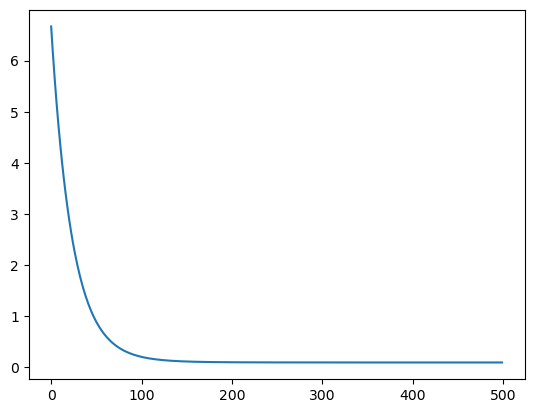

In [9]:
print(list(model.parameters()))
plt.plot(losses)

模块化编程的好处是模型的结构可以随时发生调整，而后续的循环、优化等部分的代码可以保持不变。例如，假设我们此时希望加入一个截距项，可以把模型修改为如下形式：

In [10]:
class MyModel(nn.Module):
    def __init__(self, beta_dim):
        super(MyModel, self).__init__()
        self.bhat = nn.Parameter(torch.randn(beta_dim))
        self.b0 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        yhat = torch.matmul(x, self.bhat) + self.b0
        return yhat

np.random.seed(123456)
torch.random.manual_seed(123456)

model = MyModel(beta_dim=p)
print(list(model.parameters()))

[Parameter containing:
tensor([ 1.8645,  0.4071, -1.1971,  0.3489, -1.1437], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


接下来模型训练的代码可以不做任何改变：

iteration 0, loss = 0.10102550685405731
iteration 50, loss = 0.09571389853954315
iteration 100, loss = 0.09518022835254669
iteration 150, loss = 0.0951167494058609
iteration 200, loss = 0.09510793536901474
iteration 250, loss = 0.09510650485754013
iteration 300, loss = 0.09510625153779984
iteration 350, loss = 0.09510622173547745
iteration 400, loss = 0.09510618448257446
iteration 450, loss = 0.09510619193315506
[Parameter containing:
tensor([ 1.8301,  0.4255, -1.2002,  0.3755, -1.0897], requires_grad=True), Parameter containing:
tensor([0.0094], requires_grad=True)]


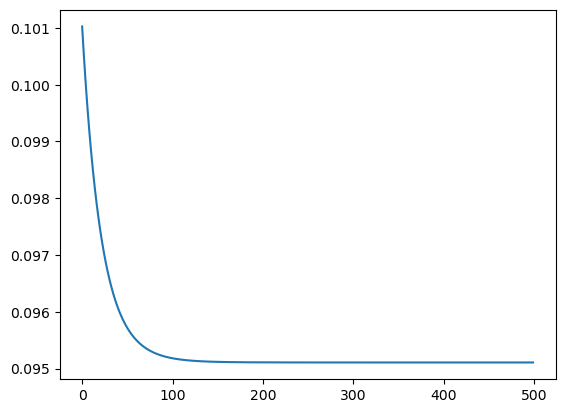

In [11]:
# 迭代次数
nepoch = 500
# 学习率，即步长
learning_rate = 0.01
# 记录损失函数值
losses = []

opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(nepoch):
    yhat = model(x)
    loss = torch.mean(torch.square(y - yhat))

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}")

print(list(model.parameters()))
plt.plot(losses)